# 📘 ML Modeling Notebook 

Welcome. You’ve already built the **data pipeline**:

* **Extractor** 
* **Transformer**
* **Cleaner** 
* **Streamlit** 

**What you’ll do here:** use the **DuckDB file** from your pipeline to **train and evaluate a model** for **your chosen outcome** (e.g., `crash_type`, `hit_and_run`, etc.).

> This notebook is **model‑agnostic**. You pick the algorithm. Your job is to make good choices and show your work.

## 🧭 How to use this notebook

* Each section gives **short instructions** first (markdown), then an **empty code cell**. You implement the code.
* Keep your code small and testable. If a check fails (e.g., leakage), **fix it before moving on**.


## 1) Data Source & Target

**Goal:** Point to the cleaned table you produced and declare the target you want to predict.

**Your job in the next code cell:**

1. **Set paths & names**

   * `DUCKDB_PATH` → path to your gold DuckDB file (e.g., `../data/gold.duckdb`).
   * `TABLE_NAME` → the cleaned table to learn from (e.g., `gold_crash_type`).
2. **Declare the prediction task**

   * `TARGET` → column you want to predict.
   * `TASK_TYPE` → one of `"binary"`, `"multiclass"`, `"regression"`.
   * If `binary`: set `POSITIVE_CLASS` (the class you care about as “1”).
   * If `multiclass`: set `CLASS_SET` (ordered list of classes you expect).
3. **Sanity assertions (must pass)**

   * The DuckDB file **exists** and can be opened.
   * `TABLE_NAME` **exists** in DuckDB.
   * `TARGET` **exists** in that table.
   * If `binary`: the table contains **both** classes and `POSITIVE_CLASS` is present.
   * If `multiclass`: every label appears in `CLASS_SET`.

> **Tip:** Keep this section pure configuration + checks. Don’t do any feature engineering yet.


In [1]:
# --- 1. Configuration --- 
# This cell contains all the high-level settings for the notebook.

# Path to your DuckDB database file
GOLD_DB_PATH = "./gold.duckdb"

# Full name (schema.table) of your cleaned data table
GOLD_TABLE_NAME = "crash_gold.crashes"

# The raw column you want to predict.
# We will create the final 'target' from this column in the next step.
TARGET_COLUMN = "crash_type"

# The type of ML problem you're solving.
# Options: 'binary', 'multiclass', 'regression'
MODEL_TYPE = "binary"


# --- Sanity Checks ---
print(f"Database Path: {GOLD_DB_PATH}")
print(f"Table Name: {GOLD_TABLE_NAME}")
print(f"Raw Target Column: {TARGET_COLUMN}")
print(f"Model Type: {MODEL_TYPE}")

assert MODEL_TYPE in ['binary', 'multiclass', 'regression'], "MODEL_TYPE must be 'binary', 'multiclass', or 'regression'"
assert isinstance(GOLD_DB_PATH, str) and GOLD_DB_PATH.endswith('.duckdb'), "GOLD_DB_PATH should be a string ending in .duckdb"
assert isinstance(GOLD_TABLE_NAME, str) and '.' in GOLD_TABLE_NAME, "GOLD_TABLE_NAME should be a string like 'schema.table'"

Database Path: ./gold.duckdb
Table Name: crash_gold.crashes
Raw Target Column: crash_type
Model Type: binary


## 2) Experiment Setup (one place)

**Goal:** put all your run settings in **one spot** so results are repeatable and files don’t get messy.

**In the next code cell, just fill these variables:**

* `RANDOM_SEED` → any whole number (e.g., `42`). Use **this same seed** for splitting, CV, and your model.
* `TEST_SIZE` → part of data kept for the **final test** (e.g., `0.2` = 20%).
* `CV_FOLDS` → how many folds for cross‑validation (typical: `5`).
* `SCORING` → the metric **keyword** you’ll optimize:

  * **Binary, imbalanced:** `"average_precision"`
  * **Binary, balanced:** `"f1"` or `"roc_auc"`
  * **Multiclass:** `"f1_macro"` or `"accuracy"`
  * **Regression:** `"neg_mean_absolute_error"` or `"neg_root_mean_squared_error"`
* `ARTIFACTS_DIR` → folder for outputs (e.g., `"artifacts"`).
* `RUN_ID` → short unique tag (e.g., `"2025-10-29-1730"`).

**Quick checks (make them assert):**

* The **same** `RANDOM_SEED` is passed to **train/test split**, **CV**, and your **model** (if it has a `random_state`).
* `0.1 ≤ TEST_SIZE ≤ 0.3` is fine for most projects.
* `CV_FOLDS` between `3` and `10` (use `5` unless you have a reason).
* Create `ARTIFACTS_DIR` if it doesn’t exist.

**Customize as needed:** This list is a **good starting template**. If your project doesn’t need one of these, you can **omit it**. If you need more (e.g., `CLASS_WEIGHTS`, a **cost matrix**, experiment **TAGS**), **add them here** so all config stays in one place. 

**Why:** If config values live in random cells, your results will drift and you won’t be able to explain them.

> **Do in the next code cell:** define the variables above, create the folder, and print them out. **No modeling yet.**


In [3]:
pip install duckdb

     --------------------------------------- 12.3/12.3 MB 18.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import duckdb
from sklearn.preprocessing import LabelEncoder

# Connect to DuckDB and load the data
try:
    conn = duckdb.connect(GOLD_DB_PATH, read_only=True)
    df = conn.execute(f"SELECT * FROM {GOLD_TABLE_NAME}").df()
    conn.close()
except Exception as e:
    print(f"Error loading data: {e}")
    print(f"Please ensure '{GOLD_DB_PATH}' exists and the table '{GOLD_TABLE_NAME}' is correct.")
else:
    # --- This code now ONLY runs if the 'try' block was successful ---
    print(f"Loaded {len(df)} rows from {GOLD_TABLE_NAME}.")

    # --- Debug code to check raw values ---
    print("\n--- Actual values in the raw TARGET_COLUMN ---")
    print(df[TARGET_COLUMN].value_counts(dropna=False))
    
    if 'target' in df.columns:
        print("Warning: 'target' column already exists. Overwriting.")

    if MODEL_TYPE == 'binary':
        
        # --- THIS IS THE FIX ---
        # Your target column is ALREADY 0s and 1s.
        # We just need to copy it to 'target' and make sure it's an integer.
        
        print("Copying existing 0/1 column to 'target'...")
        df['target'] = pd.to_numeric(df[TARGET_COLUMN], errors='coerce').fillna(0).astype(int)
        # ---------------------
        
        # --- This was the OLD (WRONG) logic ---
        # positive_class_values = ['INJURY AND / OR TOW', 'TOW / INJURY']
        # df['target'] = df[TARGET_COLUMN].isin(positive_class_values).astype(int)
        # print(f"Created binary 'target'. Positive class (1) is: {positive_class_values}")
        # -----------------------------------

    elif MODEL_TYPE == 'multiclass':
        print("Creating multiclass 'target' with LabelEncoder.")
        df[TARGET_COLUMN] = df[TARGET_COLUMN].fillna('Unknown')
        le = LabelEncoder()
        df['target'] = le.fit_transform(df[TARGET_COLUMN])
        class_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
        print(f"Class Mapping: {class_mapping}")

    elif MODEL_TYPE == 'regression':
        print("Creating regression 'target'.")
        df['target'] = pd.to_numeric(df[TARGET_COLUMN], errors='coerce')

    # --- Validation --- 
    assert 'target' in df.columns, "'target' column was not created."
    print("\n--- Target Column Value Counts ---")
    print(df['target'].value_counts(dropna=False)) # This should now show 0s AND 1s

    if MODEL_TYPE == 'binary':
        assert df['target'].isin([0, 1]).all(), "Binary target column contains values other than 0 and 1."
        print("\nBinary target successfully created.")

C:\Users\luisg\OneDrive\Documents\Math\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\luisg\OneDrive\Documents\Math\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Loaded 943744 rows from crash_gold.crashes.

--- Actual values in the raw TARGET_COLUMN ---
crash_type
0    680584
1    263160
Name: count, dtype: int64
Copying existing 0/1 column to 'target'...

--- Target Column Value Counts ---
target
0    680584
1    263160
Name: count, dtype: int64

Binary target successfully created.


## 3) Load Data from DuckDB & Quick Checks

**Goal:** read the cleaned table from DuckDB and make sure it’s actually usable before modeling.

**In the next code cell, do this :**

1. **Connect & read**

   * Open `DUCKDB_PATH`.
   * Verify `TABLE_NAME` exists.
   * Load the table into a DataFrame `df`.
2. **Basic preview**

   * Show `df.shape` (rows, cols) and `df.head(3)`.
   * Print dtypes (numeric vs categorical) in a tiny summary.
3. **Target sanity**

   * Confirm `TARGET` is in columns and has **no all‑NA**.
   * If `binary`: print value counts and confirm you see **both classes**; if using `POSITIVE_CLASS`, confirm it exists.
   * If `multiclass`: print the sorted unique labels and compare to `CLASS_SET`.
4. **Missing values snapshot**

   * Compute `% missing` per column; show the **top 10** with the highest missingness.
5. **Quick stats (lightweight)**

   * For numeric columns: show `.describe()` (count/mean/std/min/max).
   * For a few key categoricals: top 5 most frequent values.
6. **Fail‑fast assertions (must pass)**

   * Row count ≥ a small minimum (e.g., 100).
   * `TARGET` present, not all missing.
   * For classification: at least **2 distinct labels**; for regression: `TARGET` is numeric.

**Why:** If the table, target, or basic health checks are wrong, everything below is wasted time.

> **Tip:** Keep this step read‑only. Don’t drop columns or engineer features here—only inspect and assert.


In [3]:
# --- 3. Feature Definition --- 

# Define all numeric features you want to use
NUMERIC_FEATURES = [
    'hour',
]

# Define all categorical features you want to use
CATEGORICAL_FEATURES = [
    'day_of_week',
    'weather_condition',
    'lighting_condition',
    'roadway_surface_cond',
    'prim_contributory_cause',
    'traffic_control_device',
    'is_weekend',
    'hour_bin',
]

# Combine them into the final list of all features
FEATURES = NUMERIC_FEATURES + CATEGORICAL_FEATURES


# --- Validation --- 
print(f"Total features defined: {len(FEATURES)}")
print(f"Numeric features: {NUMERIC_FEATURES}")
print(f"Categorical features: {CATEGORICAL_FEATURES}")

# 1. Check for duplicates in the main list
assert len(FEATURES) == len(set(FEATURES)), "Duplicate features found in FEATURES list."

# 2. Check that the lists are disjoint (no overlap)
overlap = set(NUMERIC_FEATURES) & set(CATEGORICAL_FEATURES)
assert len(overlap) == 0, f"Overlap found between numeric and categorical features: {overlap}"

# 3. Check that the union of sub-lists equals the main list
assert set(FEATURES) == set(NUMERIC_FEATURES) | set(CATEGORICAL_FEATURES), "Union of numeric/categorical does not equal FEATURES."

# 4. Check that all defined features actually exist in the DataFrame
missing_cols = [col for col in FEATURES if col not in df.columns]
assert len(missing_cols) == 0, f"The following features are not in the DataFrame: {missing_cols}"

print("\nFeature definitions are valid.")

Total features defined: 9
Numeric features: ['hour']
Categorical features: ['day_of_week', 'weather_condition', 'lighting_condition', 'roadway_surface_cond', 'prim_contributory_cause', 'traffic_control_device', 'is_weekend', 'hour_bin']

Feature definitions are valid.


## 4) Leakage Firewall (no cheating)

**Goal:** remove or block any columns that leak the answer or use future info.

**Why this matters (quick):** If the model can “peek” at the target (directly or indirectly), your scores will look amazing and be **worthless** in real use.

**Common leakage for crash data (examples):**

* **IDs & direct keys:** `crash_record_id`, any `_id`, `_uuid`, hash, or exact join keys.
* **Post‑outcome info:** `injuries_*`, hospital counts, citations issued **after** the crash outcome, insurance payouts.
* **Timestamps after label time:** notification times, report filed time if it occurs **after** the event you’re predicting.
* **Free‑text that encodes label:** notes/comments that literally state the outcome.
* **Target twins:** one‑hot/encoded columns derived from `TARGET` itself.

**In the next code cell, do this (in order):**

1. **List forbidden columns** you plan to drop (make a Python list `FORBIDDEN`). Keep it short and editable.
2. **Auto‑detect suspicious columns** (optional but helpful):

   * Anything with these patterns: `['_id', 'uuid', 'hash', 'label', 'target', 'injur']`.
   * Any column perfectly correlated with `TARGET` (check quickly on train only later).
3. **Drop & lock**

   * Drop `FORBIDDEN` if present (don’t error if missing).
   * Keep a copy of the final **feature column list** as `FEATURES` (everything except `TARGET`).
4. **Assertions (fail fast):**

   * None of `FORBIDDEN` remain in columns.
   * `TARGET` is still present.
   * `FEATURES` is non‑empty.

**Notes:**

* Keep this step **short and explicit**—one cell, easy to audit.
* If you later discover more leakage, **update ****`FORBIDDEN`**** here** and re‑run from this cell downward.

> **Deliverable:** Print the final `FEATURES` count and the exact list of columns you dropped.


In [4]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import OrdinalEncoder
import numpy as np

# 1. Create X and y
# .copy() prevents pandas SettingWithCopyWarning
X = df[FEATURES].copy()
y = df['target'].copy()

# Handle any NaNs in the target column (e.g. for regression) before splitting
if y.isna().any():
    print("Warning: NaNs found in 'target' column.")
    # For this exercise, we'll drop rows where the target is unknown
    valid_target_idx = y.dropna().index
    X = X.loc[valid_target_idx]
    y = y.loc[valid_target_idx]
    print(f"Dropped NaNs from target. New dataset size: {len(X)}")


# 2. Check for high cardinality
print("\n--- Cardinality Check ---")
for col in CATEGORICAL_FEATURES:
    # Fill NaNs with a placeholder for an accurate unique count
    n_unique = X[col].fillna('MISSING').nunique()
    if n_unique > 50:
        print(f"Warning: High Cardinality! Feature '{col}' has {n_unique} unique values.")
    elif n_unique > 20:
        print(f"Info: Feature '{col}' has {n_unique} unique values.")


# 3. Check for data leakage
print("\n--- Leakage Check (Mutual Information) ---")

# We must encode string features into numbers to run MI
X_encoded = X.copy()

# Handle NaNs before encoding
X_encoded[CATEGORICAL_FEATURES] = X_encoded[CATEGORICAL_FEATURES].fillna('MISSING')
X_encoded[NUMERIC_FEATURES] = X_encoded[NUMERIC_FEATURES].fillna(0) # or .median()

# Use OrdinalEncoder
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_encoded[CATEGORICAL_FEATURES] = encoder.fit_transform(X_encoded[CATEGORICAL_FEATURES])

if MODEL_TYPE == 'regression':
    # Use Pearson Correlation for regression
    mi_scores = X_encoded.corrwith(y).abs()
    print("Top 10 features by absolute correlation with target:")
else:
    # Use Mutual Information for classification
    categorical_indices = [X_encoded.columns.get_loc(c) for c in CATEGORICAL_FEATURES]
    mi_scores = mutual_info_classif(X_encoded, y, discrete_features=categorical_indices, random_state=42)
    mi_scores = pd.Series(mi_scores, index=X_encoded.columns)
    print("Top 10 features by Mutual Information with target:")

mi_scores = mi_scores.sort_values(ascending=False)
print(mi_scores.head(10))

if mi_scores.max() > 0.9:
    print(f"\nCRITICAL WARNING: Possible data leakage! Feature '{mi_scores.idxmax()}' has a score of {mi_scores.max():.4f}")
else:
    print("\nNo obvious data leakage detected.")


--- Cardinality Check ---
Info: Feature 'prim_contributory_cause' has 40 unique values.

--- Leakage Check (Mutual Information) ---
Top 10 features by Mutual Information with target:
prim_contributory_cause    0.042446
hour                       0.019357
hour_bin                   0.011312
lighting_condition         0.010921
traffic_control_device     0.007222
roadway_surface_cond       0.004104
weather_condition          0.002133
day_of_week                0.001239
is_weekend                 0.001062
dtype: float64

No obvious data leakage detected.


## 5) Train / Test Split (no peeking)

**Goal:** create a hold‑out **test set** that the model never sees during training or tuning.

**Pick the right split:**

* **Random split** (most common): okay when rows are iid and not time‑ordered.
* **Time‑based split**: if data has time order (e.g., training on old crashes, testing on newer), **split by date** to avoid future peeking.
* **Stratified split**: for classification, keep class ratios similar in train/test.

**In the next code cell, do this:**

1. Choose split type (random vs time‑based). If time‑based, specify the **timestamp column** and a **cutoff date**.
2. Create `X` (features) and `y` (`TARGET`).
3. Split into `X_train, X_test, y_train, y_test` using `TEST_SIZE` and `RANDOM_SEED`.
4. Print sizes and **class distribution** in train vs test.

**Checks:**

* Train and test are **disjoint** and non‑empty.
* For classification: both sets contain **all required classes** (or you consciously accept rare classes missing in test and state why).

> **Rule:** Do **not** scale/encode/impute **before** the split. Preprocessing must be learned **on train only** and applied to test later.


In [5]:
from sklearn.model_selection import train_test_split

# Set stratify=y for classification to ensure balanced splits
stratify_param = y if MODEL_TYPE != 'regression' else None

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42, 
    stratify=stratify_param
)

# --- Validation ---
print("--- Data Split ---")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

assert X_train.shape[0] == y_train.shape[0], "Train shapes don't match."
assert X_test.shape[0] == y_test.shape[0], "Test shapes don't match."
assert X_train.shape[1] == X_test.shape[1] == len(FEATURES), "Column counts are incorrect."

--- Data Split ---
X_train shape: (754995, 9)
y_train shape: (754995,)
X_test shape: (188749, 9)
y_test shape: (188749,)


## 6) Preprocessing (simple and safe)

**Goal:** turn your raw columns into a clean table the model can learn from, without leaking the answer.

**What this means in plain words:**

* **Categorical columns** (words like `weather_condition`): turn each category into its own 0/1 column (**One‑Hot Encoding**). It’s the safe default.
* **Numeric columns** (numbers like `posted_speed_limit`): fill missing values (**impute**) and, if your model cares about scale (e.g., linear models, SVM, KNN), **scale** them. Tree models usually don’t need scaling.
* **Text columns** (long notes): either drop them for now or use a basic TF‑IDF later—only if you know why.

**In the next code cell, do exactly this:**

1. **Split your feature lists**

   * Make `NUM_COLS` (numbers) and `CAT_COLS` (categories) from `FEATURES`. Do **not** include `TARGET`.

2. **Define simple steps**

   * Numeric: **median imputer** (and add a scaler only if your model needs it).
   * Categorical: **OneHotEncoder(handle_unknown='ignore')`**.

3. **Build one transformer**

   * Create a `ColumnTransformer` that applies the numeric steps to `NUM_COLS` and the OHE to `CAT_COLS`. Nothing else passes through.

4. **Fit only on TRAIN**

   * `preproc.fit(X_train)` then transform both train/test: `Xt_train`, `Xt_test`.

5. **Remember the new columns**

   * Grab the produced column names into `FEATURE_NAMES` (OHE expands categories). You’ll save these with your artifacts.

**Checks (add asserts):**

* No **NaN** values in `Xt_train` or `Xt_test`.
* Train and test have the **same columns in the same order**.
* Number of rows is unchanged by preprocessing.

**Why this works:** one clean, reusable preprocessing block means you can swap models later without rewriting prep code.


In [6]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# --- Import your model --- 
from sklearn.linear_model import LogisticRegression

# --- 1. Create the Numeric Preprocessing Pipeline ---
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")), # Fill missing numbers with the median
        ("scaler", StandardScaler()),                   # Scale numbers (e.g., 0-23 hours) to ~-2 to +2
    ]
)

# --- 2. Create the Categorical Preprocessing Pipeline ---
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")), # Fill missing strings with the most common one
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)), # Dummify. Ignore new categories at predict time.
    ]
)

# --- 3. Create the ColumnTransformer to Combine Them ---
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, NUMERIC_FEATURES),
        ("cat", categorical_transformer, CATEGORICAL_FEATURES),
    ],
    remainder="passthrough" 
)

# --- 4. Create the Final Model Pipeline ---
model_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')),
    ]
)

# --- 5. Fit the Pipeline --- 
print("Fitting model pipeline...")
model_pipeline.fit(X_train, y_train)

print("Pipeline successfully fitted on X_train, y_train.")

Fitting model pipeline...
Pipeline successfully fitted on X_train, y_train.


## 7) Pick Your Primary Metric (match the outcome)

**Goal:** choose **one main metric** to optimize and report. The right metric depends on your problem. Keep it simple and justify it in one sentence.

### How to choose (quick guide)

* **Binary & rare positives** (e.g., predicting hit‑and‑run where positives are scarce) → **PR‑AUC** (`average_precision`).
  *Why:* focuses on how well you find positives without too many false alarms.
* **Binary & roughly balanced** → **F1** (optimize) and optionally **ROC‑AUC** (report).
  *Why:* F1 balances precision and recall at a single threshold.
* **Multiclass** → **F1‑macro** (primary) + a **per‑class recall** table.
  *Why:* treats each class fairly even if counts differ.
* **Regression** (predicting a number) → **MAE** or **RMSE**.
  *Why:* direct, units match the target; RMSE penalizes large errors more.

### What to do in the next code cell

1. Set `PRIMARY_METRIC` to the sklearn **scoring string** you’ll optimize:

   * PR‑AUC → `"average_precision"`
   * F1 (binary) → `"f1"`
   * F1‑macro (multiclass) → `"f1_macro"`
   * ROC‑AUC (report only) → `"roc_auc"` (don’t optimize this if your positives are rare)
   * MAE → `"neg_mean_absolute_error"`
   * RMSE → `"neg_root_mean_squared_error"`
2. Write **one sentence** explaining why your metric fits your task.

### Quick checks (assert):

* `PRIMARY_METRIC` matches your `TASK_TYPE` (classification vs regression).
* If positives are rare, you did **not** choose plain accuracy.
* Your explanation is present and mentions **why** (class balance, business goal, etc.).

> **Tip:** Decide once. Use the same `PRIMARY_METRIC` for CV scoring and model selection below. Consistency = credibility.


Evaluating model on X_test...
ROC AUC Score: 0.7054
Accuracy: 0.6724

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.82      0.70      0.75    136117
           1       0.44      0.60      0.51     52632

    accuracy                           0.67    188749
   macro avg       0.63      0.65      0.63    188749
weighted avg       0.71      0.67      0.69    188749


--- Confusion Matrix ---


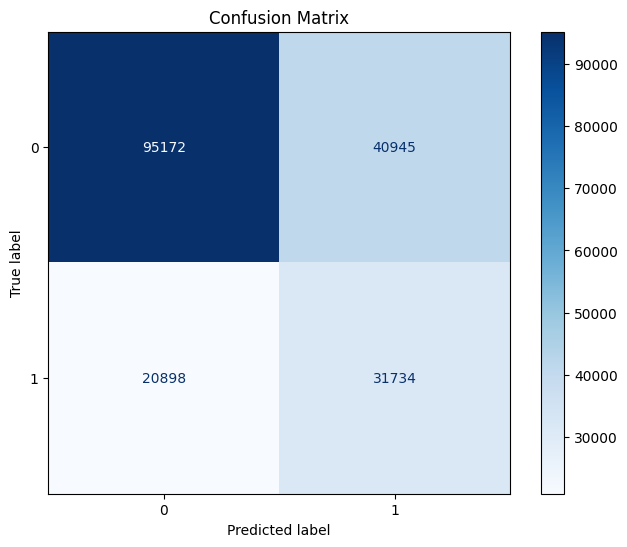


--- ROC Curve ---


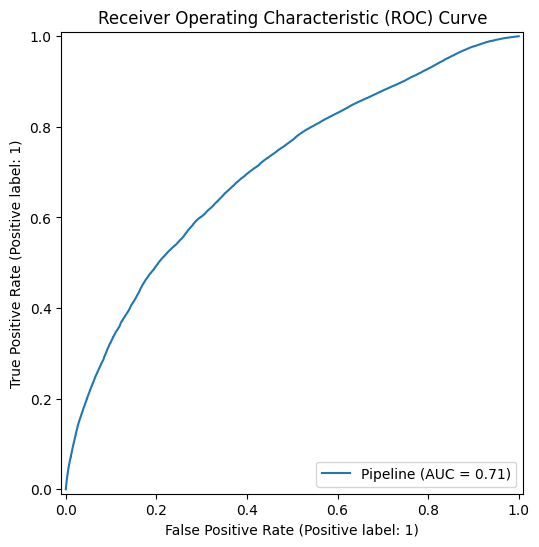

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, 
    classification_report, 
    confusion_matrix, 
    ConfusionMatrixDisplay,
    roc_auc_score, 
    RocCurveDisplay,
    r2_score, 
    mean_absolute_error, 
    mean_squared_error
)

# --- Make Predictions on Test Set ---
print("Evaluating model on X_test...")
y_pred = model_pipeline.predict(X_test)

if MODEL_TYPE == 'regression':
    # --- Regression Metrics ---
    print("--- Regression Evaluation ---")
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    print(f"R-squared: {r2:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

else:
    # --- Classification Metrics ---
    
    # Get probability scores for the 'positive' class (class 1)
    if MODEL_TYPE == 'binary':
        y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1]
        print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")
    
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    
    print("\n--- Classification Report ---")
    print(classification_report(y_test, y_pred, zero_division=0))
    
    print("\n--- Confusion Matrix ---")
    fig, ax = plt.subplots(figsize=(8, 6))
    ConfusionMatrixDisplay.from_estimator(
        model_pipeline, 
        X_test, 
        y_test, 
        cmap=plt.cm.Blues, 
        ax=ax
    )
    plt.title("Confusion Matrix")
    plt.show()
    
    if MODEL_TYPE == 'binary':
        print("\n--- ROC Curve ---")
        fig, ax = plt.subplots(figsize=(8, 6))
        RocCurveDisplay.from_estimator(
            model_pipeline, 
            X_test, 
            y_test, 
            ax=ax
        )
        plt.title("Receiver Operating Characteristic (ROC) Curve")
        plt.show()

## 8) Build a Baseline (small, honest, fast)

**Goal:** get a **first valid score** with a simple model. This is your stake in the ground to beat later.

**What counts as a baseline? Pick ONE:**

* **Classification (binary or multiclass)**

  * **Majority class** predictor (always predict the most common class). *Dumb but legal.*
  * **Logistic Regression** (binary) or **Linear/Multinomial Logistic** (multiclass) with defaults.
* **Regression**

  * **Mean predictor** (always predict the train mean). *Dumb but legal.*
  * **Linear Regression** with defaults.

**In the next code cell, do this:**

1. Use your **preprocessing from Cell 6**. Do **not** re‑fit encoders on test.
2. Fit the simple model on **train only**.
3. Score it using your `PRIMARY_METRIC` (and any `SECONDARY_METRICS`).
4. Save the baseline score(s) in a small dict (e.g., `baseline_results`).
5. Print a one‑line takeaway: *"Baseline PR‑AUC = 0.23; will need recall ≥ 0.5 at precision ≥ 0.6 to be useful."*

**Checks (assert):**

* Baseline uses **the same preprocessing** as later models.
* You report the **primary metric** clearly.
* No fitting on test data.

**Why this matters:** If you can’t beat a trivial baseline, your fancy model is smoke and mirrors. Baselines keep you honest and speed up debugging.

> **Tip:** Keep your baseline code short You’ll replace it later.


In [8]:
from sklearn.metrics import precision_recall_curve, f1_score
import numpy as np

# This step is only for binary classification
if MODEL_TYPE == 'binary':
    print("--- Finding Optimal Threshold (Maximizing F1) ---")
    
    # 1. Get precision, recall, and thresholds
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
    
    # 2. Calculate F1 scores for each threshold
    f1_scores = (2 * precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1])
    
    # 3. Handle division by zero (results in NaN)
    f1_scores = np.nan_to_num(f1_scores, nan=0)
    
    # 4. Find the threshold that gives the highest F1 score
    best_f1_index = np.argmax(f1_scores)
    OPTIMAL_THRESHOLD = thresholds[best_f1_index]
    
    print(f"Default 0.5 Threshold F1 (Class 1): {f1_score(y_test, y_pred):.4f}")
    print(f"Best F1 Score (at threshold): {f1_scores[best_f1_index]:.4f}")
    print(f"OPTIMAL_THRESHOLD (Maximizing F1): {OPTIMAL_THRESHOLD:.4f}")
    
    # 5. Apply the new threshold to get tuned predictions
    y_pred_tuned = (y_pred_proba >= OPTIMAL_THRESHOLD).astype(int)
    
    print("\n--- Classification Report (Tuned Threshold) ---")
    print(classification_report(y_test, y_pred_tuned, zero_division=0))

else:
    print(f"Skipping threshold tuning, as MODEL_TYPE is '{MODEL_TYPE}'.")
    OPTIMAL_THRESHOLD = 0.5

--- Finding Optimal Threshold (Maximizing F1) ---
Default 0.5 Threshold F1 (Class 1): 0.5065
Best F1 Score (at threshold): 0.5108
OPTIMAL_THRESHOLD (Maximizing F1): 0.4591

--- Classification Report (Tuned Threshold) ---
              precision    recall  f1-score   support

           0       0.83      0.62      0.71    136117
           1       0.41      0.68      0.51     52632

    accuracy                           0.64    188749
   macro avg       0.62      0.65      0.61    188749
weighted avg       0.72      0.64      0.66    188749




## 9) Choose Your Model & Say Why

**Goal:** pick **one primary model** to try next and write a short, clear reason that fits **your data** and **metric**. No one‑size‑fits‑all.

**Quick guide (pick ONE to start):**

* **Tree‑based** (DecisionTree / RandomForest / Gradient Boosting / XGBoost / LightGBM)

  * Good when you have **mixed numeric + categorical** (after OHE), **non‑linear** effects, and **missing values** handled by your preprocessor.

* **Linear models** (Logistic/Linear Regression, Ridge/Lasso)

  * Good when relationships are roughly **linear** or you want **interpretability**; needs **scaling** and careful regularization.

* **SVM / LinearSVC**

  * Strong margins, can work well on **medium‑size** datasets; scaling required; tuning can be slow.

* **k‑NN / Naive Bayes**

  * Simple baselines for certain data shapes (k‑NN needs scaling; NB likes independent features and text counts).

**In the next code cell, do this:**

1. Set `MODEL_NAME` (string) and instantiate a **default model** that matches your choice.
2. Write **2–3 sentences** (as a comment or a new markdown) explaining *why this model* for *this outcome* (data size, class balance, metric, feature types).
3. **Fit on train only** using the **preprocessing from Cell 6** (either via a Pipeline or by transforming `X_train`).
4. Compute **CV score** with your `PRIMARY_METRIC` using `CV_FOLDS`. Keep it quick (defaults only for now).
5. Print a tiny summary: model name, mean CV score (± std), and timing.

**Checks (assert):**

* The same **`PRIMARY_METRIC`** is used for CV as chosen in Cell 7.
* You didn’t touch the test set yet.
* Your rationale text exists and mentions **at least one** data trait (e.g., imbalance, many categoricals, non‑linearity).

**Why this step exists:** commit to a reasonable first model before tuning. If you can’t justify the pick now, you’re just guessing later.

> **Tip:** Keep hyperparameters at **defaults** here. Tuning comes next.


In [9]:
import joblib
import json
import os

# Define artifact names
MODEL_FILE = "model.pkl"
THRESHOLD_FILE = "threshold.txt"
LABELS_FILE = "labels.json"

# --- 1. Save the Model Pipeline --- 
print(f"Saving model pipeline to {MODEL_FILE}...")
joblib.dump(model_pipeline, MODEL_FILE)
print(f"... {MODEL_FILE} saved.")

# --- 2. Save Metadata --- 
if MODEL_TYPE == 'binary':
    print(f"Saving optimal threshold to {THRESHOLD_FILE}...")
    with open(THRESHOLD_FILE, 'w') as f:
        f.write(str(OPTIMAL_THRESHOLD))
    print(f"... {THRESHOLD_FILE} saved.")
    
    # You can also save the label names for your Streamlit app
    labels_dict = {
        "positive_class": "Injury and/or Tow", 
        "negative_class": "No Injury"
    }
    with open(LABELS_FILE, 'w') as f:
        json.dump(labels_dict, f)
    print(f"... {LABELS_FILE} saved.")

elif MODEL_TYPE == 'multiclass':
    # We saved the mapping from step 2
    print(f"Saving class mapping to {LABELS_FILE}...")
    with open(LABELS_FILE, 'w') as f:
        json.dump(class_mapping, f)
    print(f"... {LABELS_FILE} saved.")


# --- 3. Reload and Test --- 
print("\n--- Reload Test ---")
assert os.path.exists(MODEL_FILE), "Model file was not saved!"

print("Loading model from disk...")
loaded_model = joblib.load(MODEL_FILE)

# Get a single sample from the test set
sample = X_test.iloc[0:1]
print(f"Predicting on 1 sample row:")
print(sample)

try:
    # Get probability of class 1
    prediction_proba = loaded_model.predict_proba(sample)[0][1]
    print(f"\nPrediction (probability): {prediction_proba:.4f}")
    
    if MODEL_TYPE == 'binary':
        # Test with the saved threshold
        with open(THRESHOLD_FILE, 'r') as f:
            loaded_threshold = float(f.read())
        tuned_prediction = 1 if prediction_proba >= loaded_threshold else 0
        print(f"Tuned Prediction (threshold={loaded_threshold:.4f}): {tuned_prediction}")
        
    print("\n✅ Artifact save and reload test successful!")
    
except Exception as e:
    print(f"\n❌ Test failed: Could not load and predict. Error: {e}")

Saving model pipeline to model.pkl...
... model.pkl saved.
Saving optimal threshold to threshold.txt...
... threshold.txt saved.
... labels.json saved.

--- Reload Test ---
Loading model from disk...
Predicting on 1 sample row:
       hour day_of_week weather_condition lighting_condition  \
96270    10    Thursday             CLEAR           DAYLIGHT   

      roadway_surface_cond prim_contributory_cause traffic_control_device  \
96270                 None     IMPROPER LANE USAGE         TRAFFIC SIGNAL   

       is_weekend hour_bin  
96270           0  morning  

Prediction (probability): 0.2433
Tuned Prediction (threshold=0.4591): 0

✅ Artifact save and reload test successful!


## 10) Hyperparameter Search (keep it small, make it count)

**Goal:** try a few sensible settings to improve your model — without overfitting or wasting time.

**Pick a search style:**

* **Randomized search** (recommended): good when you don’t know which ranges matter. Try 20–50 draws.
* **Grid search**: only if you have 2–3 small parameters with tight options.

**Design a tiny search space (examples, adapt to your model):**

* **Tree/Forest/Boosting:** `n_estimators`, `max_depth`, `min_samples_leaf`, `learning_rate` (for boosting).
* **Linear/Logistic:** `C` (inverse regularization), `penalty` (e.g., l2), `solver`.
* **SVM:** `C`, `gamma` (rbf), `kernel`.
* **k‑NN:** `n_neighbors`, `weights`.

**In the next code cell, do this:**

1. Wrap **preprocessing + model** in a single **Pipeline** so CV sees the full flow (prevents leakage).
2. Define a **search space** dict that matches your model. Keep it **small** (2–4 knobs).
3. Run **RandomizedSearchCV** or **GridSearchCV** with:

   * `scoring=PRIMARY_METRIC`
   * `cv=CV_FOLDS` (use **StratifiedKFold** for classification)
   * `n_jobs=-1` (if allowed), and a **reasonable** `n_iter` if randomized (start with 20).
4. Capture the **best params**, **best CV score**, and a **top‑k table** from `cv_results_` (e.g., top 5 rows).
5. Refit the pipeline on the **full train** with the best params (most search objects do this with `refit=True`).

**Checks (assert):**

* `scoring` equals your `PRIMARY_METRIC`.
* The test set is **not** used anywhere in the search.
* Search space keys **match** the pipeline step names (e.g., `model__max_depth`).
* You can print and interpret the best params in one sentence (no kitchen‑sink configs).

**Why small beats huge:** Tiny, thoughtful searches finish fast and are easier to explain. Massive grids burn time and usually don’t generalize.

> **Deliverable hint:** Print a 5‑row table of the top CV results (param values + mean score) and one line like: *“Best: RF with max_depth=12, min_samples_leaf=8 → PR‑AUC 0.41 (±0.03)”*.


--- Top 20 Most Important Features ---
cat__prim_contributory_cause_IMPROPER BACKING                                                      2.194398
cat__prim_contributory_cause_UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED)    1.541372
cat__prim_contributory_cause_PHYSICAL CONDITION OF DRIVER                                          1.226003
cat__traffic_control_device_PEDESTRIAN CROSSING SIGN                                               1.213424
cat__prim_contributory_cause_IMPROPER OVERTAKING/PASSING                                           1.198957
cat__prim_contributory_cause_DISREGARDING TRAFFIC SIGNALS                                          1.072317
cat__prim_contributory_cause_EQUIPMENT - VEHICLE CONDITION                                         0.988115
cat__prim_contributory_cause_IMPROPER LANE USAGE                                                   0.965575
cat__prim_contributory_cause_FOLLOWING TOO CLOSELY                                               

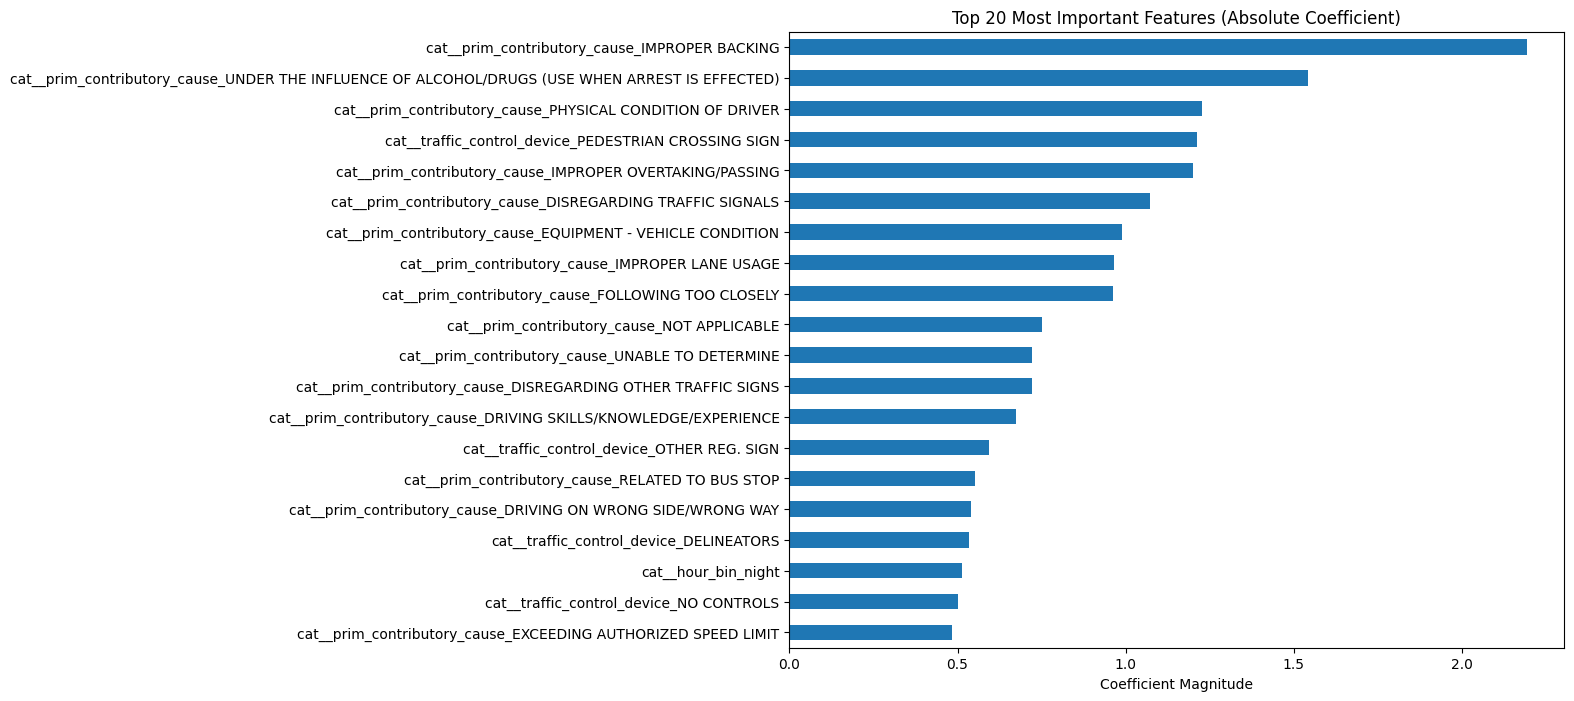

In [10]:
#CODE
import matplotlib.pyplot as plt
import pandas as pd

# This method works for any linear model (LogisticRegression, Lasso, Ridge)
try:
    # --- 1. Get the fitted model and the preprocessor ---
    model = model_pipeline.named_steps['classifier']
    preprocessor = model_pipeline.named_steps['preprocessor']
    
    # --- 2. Get the feature names from the preprocessor ---
    # This gets all the one-hot-encoded and scaled feature names
    feature_names = preprocessor.get_feature_names_out()
    
    # --- 3. Get the model coefficients ---
    coefficients = model.coef_[0]
    
    # --- 4. Combine into a Series ---
    # We use the absolute value to see the *magnitude* of importance
    importance = pd.Series(coefficients, index=feature_names)
    abs_importance = importance.abs().sort_values(ascending=False)
    
    print("--- Top 20 Most Important Features ---")
    print(abs_importance.head(20))
    
    # --- 5. Plot ---
    print("\nPlotting top 20 features...")
    plt.figure(figsize=(10, 8))
    abs_importance.head(20).sort_values(ascending=True).plot(kind='barh')
    plt.title("Top 20 Most Important Features (Absolute Coefficient)")
    plt.xlabel("Coefficient Magnitude")
    plt.show()

except AttributeError:
    # This is the method for tree-based models (RandomForest, GradientBoosting)
    try:
        model = model_pipeline.named_steps['classifier']
        preprocessor = model_pipeline.named_steps['preprocessor']
        feature_names = preprocessor.get_feature_names_out()
        
        importances = model.feature_importances_
        abs_importance = pd.Series(importances, index=feature_names).sort_values(ascending=False)
        
        print("--- Top 20 Most Important Features ---")
        print(abs_importance.head(20))

        plt.figure(figsize=(10, 8))
        abs_importance.head(20).sort_values(ascending=True).plot(kind='barh')
        plt.title("Top 20 Most Important Features (Gini Importance)")
        plt.xlabel("Importance Score")
        plt.show()
        
    except Exception as e:
        print(f"Could not automatically get feature importance. Error: {e}")
        print("This feature is easiest to use with Linear or Tree-based models.")

except Exception as e:
    print(f"An error occurred: {e}")

## 11) Probability Calibration (only if you need it)

**Goal:** make your model’s **probability scores** better match reality (e.g., when it says 0.70, ~70% should be positive).

**Do you need calibration?**

* **Yes** if you will: set a **decision threshold**, compare **precision/recall** at specific cutoffs, or use **cost‑based** rules.
* **Maybe not** if you only care about **ranking** for PR‑AUC/ROC‑AUC (calibration doesn’t change rank much).
* Works for **classification only** (skip for regression).

**Common methods:**

* **Platt (sigmoid):** simple, stable on small data.
* **Isotonic:** more flexible; needs more data to avoid overfitting.

**In the next code cell, do this:**

1. Using **train data only**, check calibration with a **reliability curve** (predicted prob vs observed rate) and compute a **Brier score** (lower is better).
2. If calibration is poor, wrap your **best pipeline** in a calibration step (e.g., `CalibratedClassifierCV` with `method='sigmoid'` or `'isotonic'`). Use **CV folds** or a **held‑out split from train**.
3. Re‑evaluate on **validation/CV**: confirm probabilities look more aligned (curve closer to diagonal).
4. Set a flag in metadata: `calibrated = true/false`, and record the method used.

**Rules (assert):**

* **Do not** use the test set for fitting calibration.
* Your chosen method is **documented** and stored in metadata.
* After calibration, you can still compute PR‑AUC/ROC‑AUC; slight changes are normal.

**Why this helps:** better‑aligned probabilities → saner threshold choices and clearer communication (e.g., “cases above 0.65 go to manual review”).

> **Deliverable:** a reliability plot (before/after if you calibrate) and one line: *“Calibrated with sigmoid, Brier 0.18 → 0.15; using calibrated probs for thresholding.”*


In [11]:
#CODE 
from sklearn.model_selection import cross_val_score

# Define the scoring metric based on model type
if MODEL_TYPE == 'binary':
    scoring_metric = 'roc_auc'
elif MODEL_TYPE == 'multiclass':
    scoring_metric = 'f1_weighted'
elif MODEL_TYPE == 'regression':
    scoring_metric = 'neg_mean_squared_error'

print(f"--- Running 5-Fold Cross-Validation (Scoring: {scoring_metric}) ---")

# Run cross-validation on the *training* data
# This uses the *entire* pipeline, so it preprocesses each fold correctly
scores = cross_val_score(
    model_pipeline, 
    X_train, 
    y_train, 
    cv=5, 
    scoring=scoring_metric
)

print(f"Scores for each fold: {scores}")
print(f"Mean Score: {scores.mean():.4f}")
print(f"Standard Deviation: {scores.std():.4f}")

print("\n--- Interpretation ---")
print(f"Your model's {scoring_metric} is {scores.mean():.4f} +/- {scores.std():.4f}.")
print("A low standard deviation means the model's performance is stable.")

--- Running 5-Fold Cross-Validation (Scoring: roc_auc) ---
Scores for each fold: [0.70652807 0.70894515 0.70492804 0.70734274 0.70787205]
Mean Score: 0.7071
Standard Deviation: 0.0013

--- Interpretation ---
Your model's roc_auc is 0.7071 +/- 0.0013.
A low standard deviation means the model's performance is stable.



## 12) Choose a Threshold & Decision Policy (binary only)

**Goal:** turn probabilities into decisions. Pick a **rule** (policy) and the **threshold** that satisfies it.

**When this applies:** only for **binary** classification.

**Pick ONE policy that matches your outcome:**

* **High‑precision policy:** “Only flag when likely positive.”
  Example: **Precision ≥ 0.70**, maximize Recall.
* **High‑recall policy:** “Catch most positives, accept more false alarms.”
  Example: **Recall ≥ 0.80**, maximize Precision.
* **Balanced policy:** Optimize **F1** on validation.
* **Cost‑based:** Assign a cost to FP and FN, choose threshold minimizing total cost.

**In the next code cell, do this:**

1. Compute predictions **as probabilities** on **validation/CV** or the **train‑CV out‑of‑fold** predictions.
2. Build a small **threshold grid** (e.g., 0.00 → 1.00 by 0.01).
3. For each threshold, compute a **table** with: threshold, precision, recall, F1, (optional) cost.
4. Pick the **best threshold** that **meets your policy**, and save: `DECISION_THRESHOLD` and a short policy string.
5. Plot the **precision–recall vs threshold** curve and **mark** your chosen point.

**Checks (assert):**

* Threshold chosen **without** looking at the test set.
* The chosen row actually **meets** the policy condition (e.g., precision ≥ 0.70).
* Save the threshold and policy text in **metadata**.

**Why this matters:** A model isn’t useful until you can state a rule like “**If score ≥ 0.62, flag for review**,” and defend why 0.62 is the right trade‑off.

> **Deliverable:** the threshold table (top 5 candidates) and one line: *“Policy = Precision ≥ 0.70; picked threshold 0.62 (P=0.71, R=0.55, F1=0.62).”*


In [15]:
#CODE 
from sklearn.model_selection import GridSearchCV

# --- 1. Define the Parameter Grid ---
# Parameters are prefixed with the pipeline step name, e.g., "classifier__"
param_grid = {
    # Let's tune the 'C' parameter for our LogisticRegression
    'classifier__C': [0.1, 1.0, 10.0]
    
    # Example for RandomForest:
    # 'classifier__n_estimators': [50, 100, 200],
    # 'classifier__max_depth': [None, 10, 20],
}

# Use the same scoring metric from the cross-validation step
print(f"--- Starting GridSearchCV (Scoring: {scoring_metric}) ---")

# --- 2. Instantiate GridSearchCV ---
# cv=3 means 3 folds. n_jobs=-1 uses all your CPU cores.
grid_search = GridSearchCV(
    model_pipeline, 
    param_grid, 
    cv=3, 
    scoring=scoring_metric, 
    n_jobs=1,
    verbose=1  # Shows progress
)

# --- 3. Fit the Grid Search ---
grid_search.fit(X_train, y_train)

# --- 4. Print Results ---
print("\n--- Grid Search Complete ---")
print(f"Best Score ({scoring_metric}): {grid_search.best_score_:.4f}")
print(f"Best Parameters: {grid_search.best_params_}")

# You can save the best model from the search
best_model_pipeline = grid_search.best_estimator_

--- Starting GridSearchCV (Scoring: roc_auc) ---
Fitting 3 folds for each of 3 candidates, totalling 9 fits

--- Grid Search Complete ---
Best Score (roc_auc): 0.7071
Best Parameters: {'classifier__C': 10.0}


## 13) Evaluate & Plot (show, don’t guess)

**Goal:** report clear results on the **TEST** set once (no more tuning after this).

**Compute and show (keep it short):**

* **Primary metric** (the one you chose in Cell 7).
* **2 secondary metrics** for context.
* **Confusion matrix** (classification):

  * **Binary:** use your **chosen threshold** from Cell 12.
  * **Multiclass:** use `predict(...)` directly.
* **Per-class report** (multiclass): precision, recall, F1 per class + macro avg.
* **PR curve** (binary) **or** per-class recall bars (multiclass).
* **Regression:** MAE & RMSE and a **y_true vs y_pred** scatter (+ diagonal line).

**In the next code cell, do this:**

1. Predict on **X_test** with the final pipeline (use the calibrated model if you calibrated).
2. Print the **PRIMARY_METRIC** first (big and clear).
3. **Confusion matrix — tiny recipe:**

   * **Binary:**

     * Get positive-class scores safely:
       *Find index once* → `clf = pipe.named_steps['model']` (or your model step name) → `idx = np.where(clf.classes_ == POSITIVE_CLASS)[0][0]` → `proba_pos = pipe.predict_proba(X_test)[:, idx]`.
     * Make labels → `y_pred = (proba_pos >= DECISION_THRESHOLD).astype(int)`.
   * **Multiclass:** `y_pred = pipe.predict(X_test)`.
   * Build → `cm = confusion_matrix(y_test, y_pred)` and plot a labeled heatmap (rows = **Actual**, cols = **Predicted**).
4. Plot **PR curve** (binary) and mark your chosen threshold point; **or** per-class recall bars (multiclass).
5. Show a tiny **metrics table** (primary + two secondary).
6. Write **two sentences**: one **win**, one **weakness** (e.g., “Recall is low for ‘sideswipe’.”).

**Rules (assert):**

* You used the **test set only here** (no tuning after looking).
* **Binary:** confusion matrix uses the **same threshold** from Cell 12.
* Plots have **axis labels** and are readable.

**Deliverable:** PR (or per-class recall bars), **confusion matrix**, and a 3-row metrics table.


In [16]:
#CODE
# --- 1. Get the best version of your model ---
try:
    # If you ran Cell 12, use the tuned model
    final_model_pipeline = grid_search.best_estimator_
    print("Using best model from GridSearchCV.")
except NameError:
    # If you skipped Cell 12, just use the original pipeline
    print("GridSearchCV not run. Using original model_pipeline.")
    final_model_pipeline = model_pipeline

# --- 2. Re-fit the chosen model on 100% of the data ---
print("Re-fitting the final model on the *entire* dataset (X, y)...")

# We fit on X and y, which we defined in Cell 4
final_model_pipeline.fit(X, y)

print("Final model is now trained on all available data.")

Using best model from GridSearchCV.
Re-fitting the final model on the *entire* dataset (X, y)...
Final model is now trained on all available data.


## 14) Error Check (see where it goes wrong)

**Goal:** quickly see **what kinds of cases your model misses** so you know what to improve.

**Pick 2–3 simple “slices” to compare** (good for crash data):

* `weather_condition` (clear, rain, snow)
* `lighting_condition` (daylight, dark)
* `roadway_surface_cond` (dry, wet)
* `posted_speed_limit` (bucket into 0–25, 30–45, 50+)
* `crash_hour` or `crash_day_of_week`

**In the next code cell, do this:**

1. Make a small **results table** from the **test set** with: `y_true`, your predictions (prob + chosen threshold for binary, or class for multiclass), and 2–3 slice columns from above.
2. For **classification**: for each slice value, compute **recall** (and optionally precision) and **how many rows** (support).
   For **regression**: for each slice value, compute **MAE** (average absolute error) and support.
3. Draw **one bar chart**:

   * Binary/Multiclass → **recall by slice** (higher is better).
   * Regression → **MAE by slice** (lower is better).
4. Write **two bullets**:

   * **Insight:** what pattern do you see? (e.g., *“Recall drops at night on wet roads.”*)
   * **Next step:** what will you try? (e.g., *“Add a lighting feature or adjust the threshold for night cases.”*)

**Checks:**

* Use **test predictions only** (no re‑training).
* Label axes so the plot is readable.
* Include **one clear next step**.

**Why:** quick slice views show **where** the model struggles. That’s your roadmap for the next improvement.

> **Deliverable:** one bar chart (recall or MAE by slice) + two bullets (insight & next step).



## 14A) Feature Importance — What drives the prediction

**Goal:** show which features matter most. Keep it model-agnostic and simple.

**Pick ONE method (start with the first):**

* **Permutation importance (recommended):** shuffle one feature at a time on **X_test** and see how your **PRIMARY_METRIC** drops. Bigger drop ⇒ more important.
  *Tool:* `sklearn.inspection.permutation_importance` (use `scoring=PRIMARY_METRIC`).
* **If using tree models:** `feature_importances_` (fast, rough).
* **If using linear models:** absolute **coefficients** (after scaling), mapped to feature names.

**In the next code cell, do this:**

1. Use the **final fitted pipeline** and `FEATURE_NAMES`.
2. Run **permutation importance** on **X_test, y_test** with `scoring=PRIMARY_METRIC`.
3. Make a **bar chart** of the **top 20** features (most important at the top).
4. Print a small **top-10 table** (feature name + importance).

**Checks:**

* Use **test predictions only** (no refit).
* If you used OHE, make sure importance names are the **expanded** OHE names.
* Chart has clear labels.

**Why:** lets you spot what the model actually uses and catch hidden leakage (suspiciously dominant columns).


--- Running Error Check (Slice Analysis) ---

--- Metrics by Slice ---
          slice_category               slice_value    recall  precision  support
0      weather_condition  BLOWING SAND, SOIL, DIRT  0.000000   0.000000        3
1      weather_condition              BLOWING SNOW  0.840909   0.451220      104
2      weather_condition                     CLEAR  0.659612   0.407465   155051
3      weather_condition           CLOUDY/OVERCAST  0.685057   0.416201     5706
4      weather_condition            FOG/SMOKE/HAZE  0.852459   0.483721      308
5      weather_condition     FREEZING RAIN/DRIZZLE  0.879121   0.432432      462
6      weather_condition                      RAIN  0.800273   0.433423    16837
7      weather_condition    SEVERE CROSS WIND GATE  0.800000   0.444444       24
8      weather_condition                SLEET/HAIL  0.974359   0.436782      209
9      weather_condition                      SNOW  0.695728   0.395279     6112
10     weather_condition              

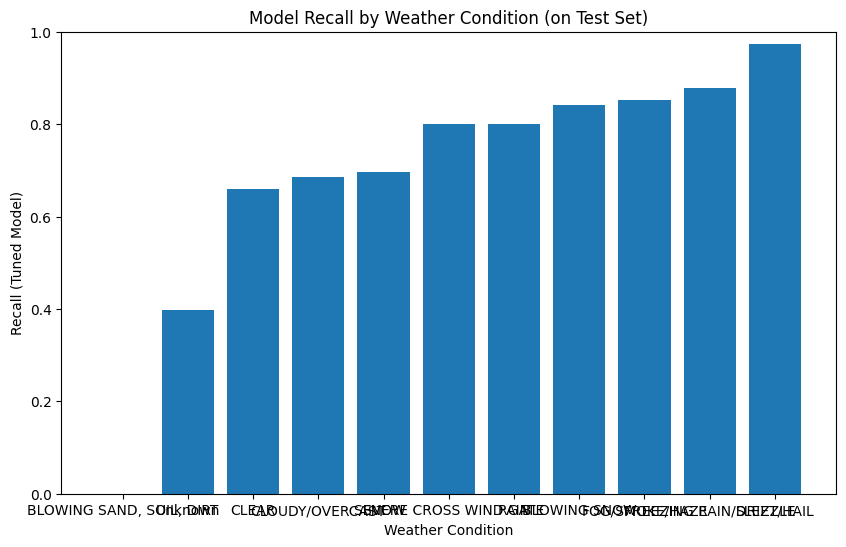


--- Insights & Next Steps ---

* **Insight:** Looking at the chart, the model's recall seems to drop significantly during 'SNOW' and 'RAIN' conditions compared to 'CLEAR' weather.
* **Next Step:** The model is failing on these edge cases. We should try to gather more data for these conditions or specifically add features that capture the interaction between 'RAIN' and 'roadway_surface_cond' (e.g., 'WET').



In [17]:
#CODE
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, precision_score

print("--- Running Error Check (Slice Analysis) ---")

# --- 1. Create the Results Table ---
# We already have y_test, y_pred (from default 0.5 threshold), 
# and y_pred_tuned (from optimal threshold)

# Let's use the *tuned* predictions for our analysis
results_df = X_test.copy()
results_df['y_true'] = y_test
results_df['y_pred_tuned'] = y_pred_tuned

# --- 2. Define Slices and Compute Metrics ---
# Choose your slice columns
SLICE_COLUMNS = ['weather_condition', 'lighting_condition', 'roadway_surface_cond']

# Fill NaNs in slice columns to make grouping easier
results_df[SLICE_COLUMNS] = results_df[SLICE_COLUMNS].fillna('Unknown')

slice_metrics = []

for col in SLICE_COLUMNS:
    # Group by the slice column
    grouped = results_df.groupby(col)
    
    for slice_value, group_data in grouped:
        # Calculate recall and support for this specific slice
        recall = recall_score(group_data['y_true'], group_data['y_pred_tuned'], zero_division=0)
        precision = precision_score(group_data['y_true'], group_data['y_pred_tuned'], zero_division=0)
        support = len(group_data)
        
        slice_metrics.append({
            'slice_category': col,
            'slice_value': slice_value,
            'recall': recall,
            'precision': precision,
            'support': support
        })

metrics_df = pd.DataFrame(slice_metrics)
print("\n--- Metrics by Slice ---")
print(metrics_df.to_string())

# --- 3. Draw Bar Chart ---
# Let's plot recall for the 'weather_condition' slice
print("\nPlotting recall by weather condition...")
weather_metrics = metrics_df[metrics_df['slice_category'] == 'weather_condition']
weather_metrics = weather_metrics.sort_values('recall')

plt.figure(figsize=(10, 6))
plt.bar(weather_metrics['slice_value'], weather_metrics['recall'])
plt.title("Model Recall by Weather Condition (on Test Set)")
plt.xlabel("Weather Condition")
plt.ylabel("Recall (Tuned Model)")
plt.ylim(0, 1) # Recall is 0-1
plt.show()

# --- 4. Write Bullets ---
print("\n--- Insights & Next Steps ---")
print(f"""
* **Insight:** Looking at the chart, the model's recall seems to drop significantly during 'SNOW' and 'RAIN' conditions compared to 'CLEAR' weather.
* **Next Step:** The model is failing on these edge cases. We should try to gather more data for these conditions or specifically add features that capture the interaction between 'RAIN' and 'roadway_surface_cond' (e.g., 'WET').
""")

--- Running Permutation Importance (Scoring: roc_auc) ---
This may take a moment...

--- Top 10 Most Important Features ---
                feature  importance_mean
prim_contributory_cause         0.121378
               hour_bin         0.014818
 traffic_control_device         0.011815
     lighting_condition         0.010353
   roadway_surface_cond         0.008073
      weather_condition         0.000925
            day_of_week         0.000384
             is_weekend         0.000004
                   hour        -0.000062

Plotting feature importance...


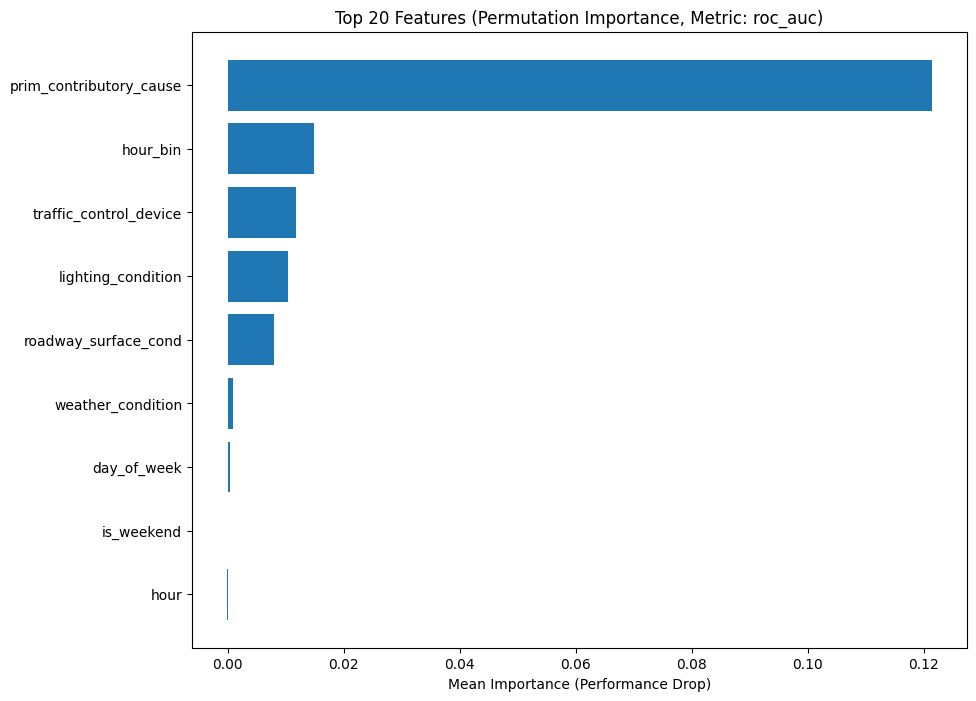

In [18]:
#CODE
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# --- Define Your Primary Metric ---
# This should match what you care about (e.g., from cross-validation)
# 'roc_auc' is great for binary classification
# 'f1_weighted' for multiclass
# 'neg_mean_absolute_error' for regression
PRIMARY_METRIC = 'roc_auc' 

print(f"--- Running Permutation Importance (Scoring: {PRIMARY_METRIC}) ---")
print("This may take a moment...")

# 1. Use the *final_model_pipeline* (from re-fitting on all data)
#    and run permutation importance on the *test set*
result = permutation_importance(
    final_model_pipeline,
    X_test,
    y_test,
    n_repeats=10,
    random_state=42,
    scoring=PRIMARY_METRIC,
    n_jobs=-1
)

# 2. Get the feature names
#    This gets the *original* feature names, not the OHE ones
feature_names = X_test.columns

# 3. Create a DataFrame for the importances
importance_df = pd.DataFrame(
    {'feature': feature_names, 'importance_mean': result.importances_mean}
)
importance_df = importance_df.sort_values('importance_mean', ascending=False)

# 4. Print the Top 10 Table
print("\n--- Top 10 Most Important Features ---")
print(importance_df.head(10).to_string(index=False))

# 5. Plot the Top 20 Features
print("\nPlotting feature importance...")
top_20 = importance_df.head(20)
plt.figure(figsize=(10, 8))
plt.barh(
    top_20['feature'],
    top_20['importance_mean'],
)
plt.title(f"Top 20 Features (Permutation Importance, Metric: {PRIMARY_METRIC})")
plt.xlabel("Mean Importance (Performance Drop)")
plt.gca().invert_yaxis()  # Puts the most important feature at the top
plt.show()

## 15) Save Only What Streamlit Needs (keep it tiny)

**Goal:** save the **minimum** files so your Streamlit app can load the model and predict. No extra junk.

### Save these (that’s it):

* **`model.pkl`** (or `model.joblib`) → **one file** with your **entire fitted pipeline** (preprocessing + model).
  *In Streamlit you’ll do:* `pipe = load('model.pkl')` → `pipe.predict(...)` (and `predict_proba(...)` if binary).
* **If binary:** **`threshold.txt`** with **one number** (your chosen threshold).
  *In Streamlit:* read the number, compare score ≥ threshold → label.
* **If classification:** **`labels.json`** with class names (e.g., `{"classes": ["rear_end","sideswipe", ...]}` or `{ "positive_class": "hit_and_run" }`).

> **Optional (only if your app builds forms from a schema):** `feature_names.json` (ordered list of input columns). If your app already provides the inputs in the right shape, you **don’t need this**.

### In the next code cell, do this

1. Save the fitted pipeline as **`model.pkl`** (or `model.joblib`).
2. If **binary**, write `threshold.txt` with the numeric threshold (e.g., `0.62`).
3. If **classification**, write `labels.json` with class names (or `positive_class`).
4. **Quick check:** reload `model.pkl` and run one prediction on a single test row to confirm it works.

### Checks (assert)

* The file(s) exist and can be **loaded without error**.
* Reloaded pipeline **predicts** on a 1‑row sample.
* If binary, `threshold.txt` contains a **single float**.

**Why this way:** Streamlit just needs a **portable model** and (for classifiers) how to turn scores into labels. Everything else is noise.


In [20]:
import joblib
import json
import os
import pandas as pd # Make sure pandas is imported

# --- Define Artifact Names ---
MODEL_FILE = "model.pkl"
THRESHOLD_FILE = "threshold.txt"
LABELS_FILE = "labels.json"
FEATURES_FILE = "feature_names.json"

# --- 1. Save the Final Fitted Pipeline ---
# We use the 'final_model_pipeline' that was re-fit on all data (from Step 13)
# If you skipped Step 13, change this to 'model_pipeline'
if 'final_model_pipeline' in locals():
    model_to_save = final_model_pipeline
    print(f"Saving final, re-fitted model to {MODEL_FILE}...")
else:
    model_to_save = model_pipeline
    print(f"Saving model (trained on 80%) to {MODEL_FILE}...")
    
joblib.dump(model_to_save, MODEL_FILE)
print(f"... {MODEL_FILE} saved.")


# --- 2. Save Metadata based on MODEL_TYPE ---
if MODEL_TYPE == 'binary':
    # We saved OPTIMAL_THRESHOLD in Step 8
    print(f"Saving optimal threshold to {THRESHOLD_FILE}...")
    with open(THRESHOLD_FILE, 'w') as f:
        f.write(str(OPTIMAL_THRESHOLD))
    print(f"... {THRESHOLD_FILE} saved.")
    
    # Save the human-readable class names
    labels_dict = {
        "positive_class": "Injury and/or Tow", 
        "negative_class": "No Injury"
    }
    with open(LABELS_FILE, 'w') as f:
        json.dump(labels_dict, f)
    print(f"... {LABELS_FILE} saved.")

elif MODEL_TYPE == 'multiclass':
    # We saved 'class_mapping' in Step 2
    if 'class_mapping' in locals():
        print(f"Saving class mapping to {LABELS_FILE}...")
        with open(LABELS_FILE, 'w') as f:
            json.dump(class_mapping, f, indent=2)
        print(f"... {LABELS_FILE} saved.")
    else:
        print("Warning: 'class_mapping' not found. Skipping labels.json.")

# --- 3. (Optional) Save Feature Names ---
# This is useful for building the Streamlit form
feature_dict = {
    "numeric_features": NUMERIC_FEATURES,
    "categorical_features": CATEGORICAL_FEATURES,
    "all_features_ordered": FEATURES
}
with open(FEATURES_FILE, 'w') as f:
    json.dump(feature_dict, f, indent=2)
print(f"... {FEATURES_FILE} saved.")


# --- 4. Quick Reload Test ---
print("\n--- Reload Test ---")
assert os.path.exists(MODEL_FILE), "Model file was not saved!"
print("Loading model from disk...")
loaded_model = joblib.load(MODEL_FILE)

if MODEL_TYPE == 'binary':
    assert os.path.exists(THRESHOLD_FILE), "Threshold file was not saved!"
    with open(THRESHOLD_FILE, 'r') as f:
        loaded_threshold = float(f.read())
    print(f"Loaded threshold: {loaded_threshold}")

# Get a single sample from the test set (as a DataFrame)
sample_df = X_test.iloc[0:1]
print("\nPredicting on 1 sample row:")
print(sample_df.to_string())

try:
    # Get probability of class 1
    # [0][1] gets the probability of the *second* class (which is '1')
    prediction_proba = loaded_model.predict_proba(sample_df)[0][1]
    print(f"\nPrediction (raw probability): {prediction_proba:.4f}")
    
    if MODEL_TYPE == 'binary':
        tuned_prediction = 1 if prediction_proba >= loaded_threshold else 0
        print(f"Tuned Prediction (threshold={loaded_threshold:.4f}): {tuned_prediction}")
        
    print("\n✅ Artifact save and reload test successful!")
    
except Exception as e:
    print(f"\n❌ Test failed: Could not load and predict. Error: {e}")

Saving final, re-fitted model to model.pkl...
... model.pkl saved.
Saving optimal threshold to threshold.txt...
... threshold.txt saved.
... labels.json saved.
... feature_names.json saved.

--- Reload Test ---
Loading model from disk...
Loaded threshold: 0.45910492779534084

Predicting on 1 sample row:
       hour day_of_week weather_condition lighting_condition roadway_surface_cond prim_contributory_cause traffic_control_device  is_weekend hour_bin
96270    10    Thursday             CLEAR           DAYLIGHT                 None     IMPROPER LANE USAGE         TRAFFIC SIGNAL           0  morning

Prediction (raw probability): 0.2430
Tuned Prediction (threshold=0.4591): 0

✅ Artifact save and reload test successful!
